# Introduction
- In this kernel, we will be implementing an example environment.
- We will be deploying SARSA, Q-Learning and Expected SARSA to try and find the optimal agent's policy and the optimal value functions, in order to maximize the rewards.

# Importing Packages & Boilerplate Stuff

1. jdc: Jupyter magic that allows defining classes over multiple jupyter notebook cells.
2. numpy: the fundamental package for scientific computing with Python.
3. matplotlib: the library for plotting graphs in Python.
4. RL-Glue: the library for reinforcement learning experiments.
5. BaseEnvironment, BaseAgent: the base classes from which we will inherit when creating the environment and agent classes in order for them to support the RL-Glue framework.
6. itertools.product: the function that can be used easily to compute permutations.
7. tqdm.tqdm: Provides progress bars for visualizing the status of loops.

In [1]:
import jdc
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import product
from tqdm import tqdm

In [2]:
### DEBUG CODE
# Setting the seed for reproducible results
# np.random.seed(0)

# 1. Environment
- The below code cell provides the backbone of the `ExampleEnvironment` class.
- There are 3 different possible actions; 0 -> LEFT, 1 -> RIGHT, 2 -> STAY.
- In states 0 and 3, LEFT and RIGHT actions will lead to the same state as STAY

In [3]:
class ExampleEnvironment():
    def __init__(self, env_info={}):
        # These are the different possible states
        self.grid = [0, 1, 2, 3]
        
        # The rewards produced by the environment in response to the different ...
        # ... actions of the agent in different states
        self.rewards = [
            [0, 0, 2],
            [0, 1, 0],
            [1, 1, 0],
            [2, 1.5, 3]
        ]

        # The environment is governed by the following dynamics
        # In mathematical notation, this is nothing but p(s'|s,a)
        # But in this example, we are assuming to be independent of actions, i.e., ...
        # p(s'|s, a) is equal for all actions in state s
        self.tran_matrix = [
            [1/2, 1/2, 0, 0],    # State 0
            [1/4, 1/4, 1/2, 0],  # State 1
            [0, 1/4, 1/4, 1/2],  # State 2
            [0, 0, 1/4, 3/4]     # State 3
        ]
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        
        # Defines the current location
        self.cur_loc = None
        
    def start(self):
        self.cur_loc = self.rand_generator.choice(self.grid)
        return self.cur_loc
    
    def step(self, action):
        next_reward = self.rewards[self.cur_loc][action]
        next_state = self.rand_generator.choice(self.grid, 
            p = self.tran_matrix[self.cur_loc])
        self.cur_loc = next_state
        return next_state, next_reward

# 2. Value Iteration

In [4]:
def value_iteration(theta = 0.01, discount = 0.9):
    # Creating an instance for the environment
    env = ExampleEnvironment()

    # Defining the paramters for the simulation
    delta = theta * 10

    # Initializing the state values and the different possible actions
    s_vals = np.zeros(4)
    actions = list(np.arange(3))

    while delta > theta:
        delta = 0
        for s in env.grid:
            cur_val = copy.copy(s_vals[s])
            vals = []
            for a in actions:
                vals.append(env.tran_matrix[s] * (env.rewards[s][a] + discount * s_vals))
            s_vals[s] = np.max(vals)
            delta = max(delta, abs(cur_val - s_vals[s]))
            
    return s_vals

In [5]:
s_vals = value_iteration(theta = 0.01, discount = 0.9)
print("Post Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

s_vals = value_iteration(theta = 0.01, discount = 0.8)
print("\nPost Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

s_vals = value_iteration(theta = 0.01, discount = 0.7)
print("\nPost Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

Post Convergence of Value Iteration Algorithm
State Values:  [1.95147145 2.11845718 3.60268576 6.90402864]

Post Convergence of Value Iteration Algorithm
State Values:  [1.6666387  1.59455804 2.74183707 5.6127556 ]

Post Convergence of Value Iteration Algorithm
State Values:  [1.5384191  1.25191428 2.15287142 4.72930713]


# 3. Q Learning Agent

In [6]:
class QLearningAgent():
    def __init__(self, agent_info={}):
        # Defining the #actions and #states 
        self.num_actions = 3
        self.num_states = 4
        
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount", 0.9)

        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size", 0.1)

        # To control the exploration-exploitation trade-off
        self.epsilon = agent_info.get("epsilon", 0.1)
        
        # To determine if the Q-function is converged or not
        self.delta = agent_info.get("delta", 0.01)
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))
        
        # Defining the initial action values
        # self.q = self.rand_generator.randn(self.num_states, self.num_actions)
        self.q = self.rand_generator.randn(self.num_states, self.num_actions)
        
        # Initializing the variables for the previous state and action
        self.prev_state  = None
        self.prev_action = None
        
    def start(self, state):
        # Choose action using epsilon greedy.
        current_q = self.q[state][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        self.prev_state = state
        self.prev_action = action
        return action
    
    def step(self, state, reward):
        # Choose action using epsilon greedy.
        current_q = self.q[state][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Determining the new Q-Value
        new_val = -1e8
        cur_val = copy.copy(self.q[self.prev_state, self.prev_action])
        for act in range(self.num_actions):
            val = cur_val + self.step_size * (
                reward + self.discount * self.q[state, act] - cur_val
            )
            new_val = max(new_val, val)
        self.q[self.prev_state, self.prev_action] = new_val
            
        # Determining if the Q-function has converged or not
        if abs(new_val - cur_val) < self.delta:
            return (action, True)
        else:
            return (action, False)
            
            
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# 4. Running Experiments

In [7]:
def run_experiment(env_info = {}, agent_info = {}, print_vals = True):
    env = ExampleEnvironment(env_info) 
    agent = QLearningAgent(agent_info)
    has_converged = False
    num_steps = 0
    
    init_state  = env.start()                 # STARTING STATE
    init_action = agent.start(init_state)     # STARTING ACTION
    next_state, next_reward = env.step(init_action)       # STARTING REWARD
    
    while not has_converged:
        next_action, has_converged = agent.step(next_state, next_reward)
        next_state, next_reward = env.step(next_action)
        
        if print_vals and num_steps % 2500 == 0:
            print(f"Time Steps Elapsed | {num_steps}")
            print("Q-Values:", agent.q)
            print()
        
        num_steps += 1
        
    print("POST CONVERGENCE\n")
    print("Optimal Action Values:")
    print(agent.q)
    
    print("\nOptimal State Values:")
    print(np.max(agent.q, axis = -1))
    
    print("\nOptimal Policy:")
    print(np.argmax(agent.q, axis = -1))
    
    return agent.q

In [8]:
# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.1,
    "epsilon": 0.1,
    "delta": 1e-2,
    "seed": 0
}

q_vals = run_experiment(env_info, agent_info)

Time Steps Elapsed | 0
Q-Values: [[ 1.7893275   0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

POST CONVERGENCE

Optimal Action Values:
[[ 3.90733658  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.90733658 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


## 4.1. Trying to understand the effect of step-size

In [9]:
step_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.1,
    "epsilon": 0.1,
    "delta": 1e-2,
    "seed": 0
}

state_vals_ss = []

for ss in step_sizes:
    print("\n\nFor step-size:", ss)
    agent_info['step_size'] = ss
    q_vals = run_experiment(env_info, agent_info, print_vals = False)
    state_vals = np.max(q_vals, axis = -1)
    state_vals_ss.append(state_vals)



For step-size: 0.1
POST CONVERGENCE

Optimal Action Values:
[[ 3.90733658  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.90733658 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For step-size: 0.2
POST CONVERGENCE

Optimal Action Values:
[[ 3.00636962  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.00636962 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For step-size: 0.3
POST CONVERGENCE

Optimal Action Values:
[[ 3.86036839  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.86036839 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For step-size: 0.4
POST CONVERGENCE

Optimal Action V

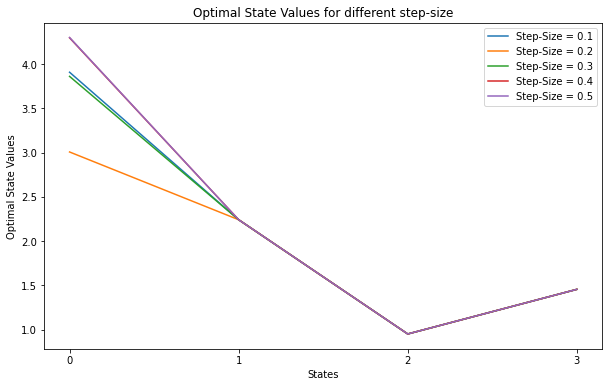

In [10]:
plt.figure(figsize = (10, 6))

for i in range(len(step_sizes)):
    plt.plot(state_vals_ss[i], label = f'Step-Size = {step_sizes[i]}')
    
plt.xticks(np.arange(4))
plt.title("Optimal State Values for different step-size")
plt.xlabel("States")
plt.ylabel("Optimal State Values")
plt.legend()
plt.show()

## 4.2. Trying to understand the effect of epsilon

In [11]:
# Trying to understand the effect of step-size
eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.1,
    "epsilon": 0.1,
    "delta": 1e-2,
    "seed": 0
}

state_vals_eps = []

for e in eps:
    print("\n\nFor epsilon:", e)
    agent_info['epsilon'] = e
    q_vals = run_experiment(env_info, agent_info, print_vals = False)
    state_vals = np.max(q_vals, axis = -1)
    state_vals_eps.append(state_vals)



For epsilon: 0.1
POST CONVERGENCE

Optimal Action Values:
[[ 3.90733658  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.90733658 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For epsilon: 0.2
POST CONVERGENCE

Optimal Action Values:
[[ 3.31991014  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.31991014 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For epsilon: 0.3
POST CONVERGENCE

Optimal Action Values:
[[ 3.31991014  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]

Optimal State Values:
[3.31991014 2.2408932  0.95008842 1.45427351]

Optimal Policy:
[0 0 0 2]


For epsilon: 0.4
POST CONVERGENCE

Optimal Action Values:
[

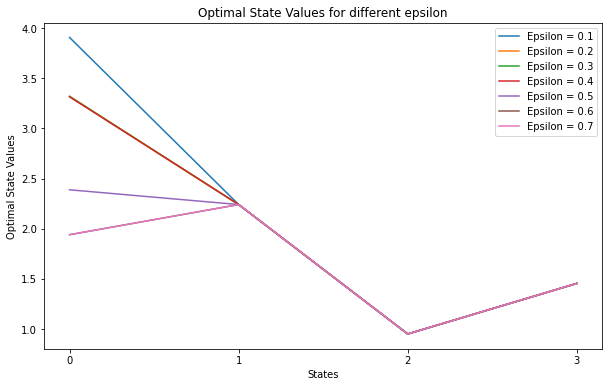

In [12]:
plt.figure(figsize = (10, 6))

for i in range(len(eps)):
    plt.plot(state_vals_eps[i], label = f'Epsilon = {eps[i]}')
    
plt.xticks(np.arange(4))
plt.title("Optimal State Values for different epsilon")
plt.xlabel("States")
plt.ylabel("Optimal State Values")
plt.legend()
plt.show()